# Hedging estático de Impermanent Loss en CPM

## Formulación Teórica

### Alcances

<a name="alcances">Nota:</a>

En el presente trabajo nos limitaremos a un estudio estático de la cuestión, razón por la cual solo tendremos un tiempo inicial y uno final, sin pasos intermedios.

Asumimos, excepto donde se aclare, que las cantidades existentes en el pool entre tiempo inicial y final respetan sin cambios la constante de producto $k$.

También asumimos que el pool se constituye inicialmente con cantidades que no permiten arbitraje.

No consideramos fees en el cálculo de la Impermanent Loss, aunque incluimos un desarrollo breve de la cuestión en el Apéndice II. El detalle del cálculo y la integración de las funciones con el resto del código quedaron fuera del alcance del presente trabajo por razones tanto de tiempo como de claridad para la exposición.

### Composición y valuación del pool

Un pool $Q$ de dos monedas X, Y puede representarse como un vector conteniendo a tiempo $T$ cantidades $x$ e $y$ respectivamente:

$$ \vec Q_T = (x, y) $$

El pool se constituye originalmente en cantidades iniciales $\vec Q_0=(x_0, y_0)$ equilibradas respecto de los precios en ese momento.

Para valuar el pool hay que sumar la valuación de sus reservas. Es decir que, teniendo un vector de valuación $\vec P_t$ a tiempo $t$, el valor del pool $Q_t$ es el siguiente producto escalar:

$$V_{Q_t}(P_t) = \vec Q_t \cdot \vec P_t$$

Para valuar las reservas $(x,y)$ con el vector $\vec P_t$, podemos valuarlas ambas en función de una de ellas (e.g., de $Y$), o bien ambas en función de una tercera moneda $Z$. Si notamos el precio de $X$ medido en unidades de $Y$ como $P_{Y|X}$, tenemos:

* Vector de valuación en función de $Y$: $\vec P = (P_{Y|X}, P_{X|X}) = (P_{Y|X}, 1) $
* Vector de valuación en función de $Z$: $\vec P = (P_{Z|X}, P_{Z|Y}) = P_{Z|Y} \cdot (P_{Y|X}, 1) $

Por lo dicho, valuar en una tercera moneda requiere simplemente aplicar un factor. Por ello, simplificaremos cuentas usando la valuación en función de $Y$. En adelante vamos a utilizar el precio $P_{Y|X}$, al cual denominaremos simplemente $P$, pues no hay confusión con el vector de valuación $\vec P$. Como dicho precio varía con el tiempo $t$, lo notaremos $\vec P_t$.

In [1]:
import numpy as np
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)                  

# Precio implícito inicial (porque asumimos no arbitraje)
def get_pool_initial_price(balances: tuple) -> float:
    return balances[1]/balances[0]

def get_pool_price_units(symbols: tuple) -> str:
    return symbols[1]

def get_initial_prices_vector(balances: tuple) -> tuple:
    return (get_pool_initial_price(pool_balances), 1) # precios del pool medidos en la unidad de pool_symbols[1]

def get_prices_vector(price: float) -> tuple:
    return (price, 1)

# Función que, dado un pool y vector de precios, devuelve el valor del pool dado.
def get_pool_value(balances: tuple, prices: tuple) -> float:
    return float(np.dot(balances, prices))



### Impermanent Loss

En su forma más sencilla, la Impermanent Loss surge de restar dos valores:
* El valor a tiempo $t$ de las cantidades $\vec Q_t$ existentes en el pool, usando sus precios $\vec P_t$.
$$V_{Pool_t} = V_{Q_t}(P_t) = \vec Q_t \cdot \vec P_t$$
* El valor a tiempo $t$ de las cantidades iniciales del pool, $\vec Q_0$, como si aún las conserváramos fuera del pool, valuadas con sus precios a tiempo $t$.
$$V_{Hold_t} = V_{Q_0}(P_t) = \vec Q_0 \cdot \vec P_t$$

La Impermanent Loss expresada en función de los precios $\vec P_t$ a tiempo $t$ es, entonces:

$$IL(\vec P_t) = V_{Pool_t} - V_{Hold_t} = (\vec Q_t-\vec Q_0) \cdot \vec P_t $$

$$ = (x-x_0, y-y_0) \cdot (P, 1)$$

$$ = (x-x_0)P + (y-y_0) $$

Pero como la idea es hedgear contra el cambio en la IL respecto de cambios en el precio, debemos expresarla como función de $P$ quitando del medio las cantidades existentes en el pool. Para ello, formulamos $V_{Pool}$ y $V_{Hold}$ de otra manera usando las siguientes identidades (ver bibliografía de referencia \[[1](#referencia1)\]):

\begin{align*}
  Ec.\ 1\ :\ \ \ \ y_t &= \sqrt{k\ P_t} \\
  Ec.\ 2\ :\ \ \ \ V_{Pool_0} &= V_{Hold_0} = 2 \sqrt{k P_0} \\
  Ec.\ 3\ :\ \ \ \ P_0 &= y_0 / x_0 \\
  Ec.\ 4\ :\ \ \ \ V_{Pool_T} &= 2 \sqrt{k P_T} \\
\end{align*}

Por la Ec. 4 tenemos:

$$  V_{Pool} = 2\sqrt{kP} $$
$$ = \frac{2\sqrt{kP_0 P}}{\sqrt{P_0}} $$
$$ = 2\sqrt{kP_0} \sqrt{\frac{P}{P_0}} $$
$$ [Ec.\ 2]\ \ \  = V_{Pool_0}\sqrt{\frac{P}{P_0}} $$

Y por la definición que dimos, tenemos:
$$ V_{Hold} = \vec Q_0 \cdot \vec P_t = (x_0, y_0) \cdot (P, 1) = x_0 P + y_0 $$

$$ [Ec.\ 1]\ \ \ \ \ \ = x_0 P + \sqrt{k P_0} $$

$$ [Ec.\ 3]\ \ \  = \frac{y_0}{P_0} P + \sqrt{k P_0} $$

$$ [Ec.\ 1]\ \ \ \ \ \  = \frac{\sqrt{k P_0}}{P_0} P + \sqrt{k P_0} $$

$$ = \sqrt{k P_0} (\frac{P}{P_0} +  1 )$$

$$  = 2\sqrt{kP_0}\frac{1}{2}(\frac{P}{P_0}+1) $$
$$ [Ec.\ 2]\ \ \ \ \ \  =\frac{V_{Hold_0}}{2}(\frac{P}{P_0}+1) $$

Nos queda entonces la siguiente fórmula de Impermanent Loss expresada en función de precios cuya unidad es la moneda $Y$:

$$IL_Y(P) = V_{Pool} - V_{Hold} $$
$$ = V_{Pool_0}\sqrt{\frac{P}{P_0}} - \frac{V_{Hold_0}}{2}(\frac{P}{P_0}+1)$$

$$ [Ec.\ 2]\ \ \ \ \ \  = V_{Hold_0}\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2} (\frac{P}{P_0}+1)\right) $$

$$ = V_{Hold_0}\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2}-\frac{P}{2P_0}\right)$$



In [44]:
# Impermanent Loss expresada en la moneda Y en función de P sin fees 
def IL_Y_P(P: any, balances: tuple) -> any:
    if type(P) == float or type(P) == np.float64 or type(P) == int:
        # Caso en que P es un número, retorno un float
        P_entry = get_pool_initial_price(balances)
        V_hold_0 = get_pool_value(balances, get_prices_vector(P_entry))
        return V_hold_0 * ((P/P_entry)**(1/2) - 1/2 - P/(2*P_entry))
    elif type(P) != np.ndarray:
        print(f'Error de tipo: {type(P)}')
        assert False # bug trap
    # Caso en que P es un array, retorno un array conteniendo los floats de los
    # resultados correspondientes a cada elemento de P.
    arr = np.array([])
    for p in P:
        arr = np.append(arr, [ IL_Y_P(p, balances) ])
    return arr


Podemos entonces calcular la derivada de $IL_Y(P)$ con respecto a P:


$$\frac{\partial}{\partial P}IL_Y(P) = V_{Hold_0}\left(\frac{\partial}{\partial P}\left(\sqrt{\frac{P}{P_0}}\right)+0-\frac{1}{2P_0}\right) $$

$$ = \frac{V_{Hold_0}}{\sqrt{P_0}}\left(\frac{\partial}{\partial P}(\sqrt{P}) - \frac{1}{2\sqrt{P_0}}\right) $$

$$ = \frac{V_{Hold_0}}{\sqrt{P_0}}\left(\frac{1}{2\sqrt{P}} - \frac{1}{2\sqrt{P_0}}\right) $$

$$ = \frac{V_{Hold_0}}{\sqrt{P_0}}\left(\frac{\sqrt{P_0}}{2\sqrt{P}\sqrt{P_0}} - \frac{1}{2\sqrt{P_0}}\right) $$

$$  = \frac{V_{Hold_0}}{2P_0}\left(\sqrt{\frac{P_0}{P}}-1\right)$$


In [3]:
# Derivada de IL expresada en la moneda Y en función de P sin fees
def IL_derivada_Y_P(P: float, balances: tuple) -> float:
    V_hold_0 = get_pool_value(balances)
    P_entry = get_pool_initial_price(balances)
    #assert V_hold_0 == 2*numpy.sqrt(balances[0]*balances[1]*P_entry)
    return V_hold_0/(2*P_entry) * ((P_entry/P)**(1/2) - 1)



### Estrategia con opciones: Long Strangle

Un provedor de liquidez ingresa al pool $Q$ depositando $x_0$  cantidad de la moneda $X$ e $y_0$ cantidad de la moneda $Y$ tales que respeten la constante del pool: $k = x_0 y_0$

A tiempo $T$ tenemos Impermanent Loss por depositar los tokens en el pool, según lo ya descripto.

Motivados por el resultado que asegura que cualquier payoff puede escribirse en terminos de bonos y opciones, proponemos usar un _Long Strangle_ como aplicacion practica para hedgearse contra la IL. La misma consiste en:

* comprar una cantidad $q_c$ de calls con strike $K_c$ del subyacente $X$
* comprar una cantidad $q_p$ de puts con strike $K_p$ del subyacente $X$

Los strikes $K_c$ y $K_p$ no pueden coincidir y se encuentran _out-the_money_ al momento inicial.

La estrategia se define típicamente para cantidades $q_c$ y $q_p$ iguales, pero es usual abarcar en ella también los casos en que difieren (para los cuales la estrategia se califica como _Unbalanced_). 

Llamaremos $d_c$ y $d_p$ a las primas respectivas.

En razón de los PnL de calls y puts, el PnL del Long Strangle a tiempo T será

$$LS_T=q_c máx(0, P_T-K_c) +q_pmáx(0,K_p-P_T) - (q_c d_c + q_pd_2)$$  









La siguiente función tiene como inputs vectores de strikes $\vec K_\text{call}$, $\vec K_\text{put}$  y de primas $\vec d_\text{call}$, $\vec d_\text{put}$  asociados a un conjunto de calls y puts. Tiene como output el PnL de considerar la combinación de estas opciones cuando el precio del subyacente es $P$.

In [74]:

# Payoff de estrategias combinando calls y puts
# Si el precio P es un array, devuelve un array 
def payoff_CP_combination(P: any,K_call, K_put,d_call,d_put,qcall,qput) -> any:
    if type(P) == float or type(P) == np.float64 or type(P) == int:
        # Caso en que P es un número, retorno un float
        call=0.0
        put=0.0
        call = call + qcall*max(P-K_call,0)
        put = put + qput*max(K_put-P,0)  
        costos = (qcall*d_call)+(qput*d_put)
        return call+put-costos
    elif type(P) != np.ndarray:
        print(f'Error de tipo: {type(P)}')
        assert False # bug trap
    # Caso en que P es un array, retorno un array conteniendo los floats de los
    # resultados correspondientes a cada elemento de P.
    arr = np.array([])
    for p in P:
        float(K_call)
        float(K_put)
        arr = np.append(arr, [ payoff_CP_combination(p, 
                                                     K_call, K_put,
                                                     d_call,d_put,
                                                     qcall,qput) ])
    return arr
  


### Hedging de IL con Long Strangle


Sea  $r_Q$ la tasa de retorno mensual del pool para los liquidity providers.

Hacer hedging de la Impermanent Loss mediante Long Strangle tiene el siguiente PnL:

$$ H_T= r_Q (V_{Pool_0}) + LS_T + IL_Y(P_T)  $$ 

$$ = r_Q (x_0+y_0 P_0)+ LS_T + IL_Y(P_T)  $$ 

Para que el hedge sea efectivo (i.e., que no esté en pérdida) buscamos que $H_T$ sea mayor o igual que cero.


In [82]:
def payoff_IL_hedgeada_con_LS(precio_T, balances_0, precio_inicial, 
                              Kcall, Kput, 
                              dcall, dput, 
                              qcall, qput, 
                              r_pool):
    V_hold_0 = get_pool_value(balances_0, get_prices_vector(precio_inicial))
    retornos_usd_pool = r_pool * V_hold_0
    value = retornos_usd_pool + \
          payoff_CP_combination(precio_T, 
                                Kcall, Kput, 
                                dcall, dput, 
                                qcall,qput) + \
          IL_Y_P(precio_T, balances_0)
    
    return value

In [76]:
payoff_IL_hedgeada_con_LS(grid*P_entry, pool_balances, precio_inicial, strike_call, strike_put, precio_call, precio_put, cant_call, cant_put, retorno_del_pool_a_tiempo_final)[1]

88000.0

## Ejemplo teórico

### Parámetros

In [80]:
# Datos iniciales del pool
# El precio P de la primera moneda se expresará en unidades de la segunda moneda.
pool_symbols = ('ETH', 'USDC')
pool_balances = (100, 400*100) # cantidades correspondientes a pool_symbols[i]


precio_inicial = get_pool_initial_price(pool_balances)

# precio_call = 0.05
# precio_put = 0.05
# strike_call = np.append(np.array([]), [precio_inicial*1.5])
# strike_put = np.append(np.array([]), [precio_inicial*0.5])


strike_call = 520
strike_put = 280
precio_call = 12
precio_put = 6

P_s = strike_call*1.05
P_i = strike_put*0.95

V_pool_0 = get_pool_value(pool_balances, get_initial_prices_vector(pool_balances))


cant_call = -V_pool_0 / 2.0 * (1/(P_s*precio_inicial)**(1/2)-1/precio_inicial)
cant_put = cant_call # strangle balanceado

cant_call = 1000
cant_put = 1000

print(f'call {cant_call}')
print(f'put {cant_put}')

#precio_final = 1650
#H_T = payoff_IL_hedgeada_con_LS(precio_final, pool_balances, precio_inicial, strike_call, strike_put, precio_call, precio_put, cant_call, cant_put, retorno_del_pool_a_tiempo_final)
#print(H_T)

print(f'Composición inicial del pool: {pool_balances[0]} {pool_symbols[0]} + {pool_balances[1]} {pool_symbols[1]}')
print(f'Precio inicial $P_0$ de {pool_symbols[0]} = {get_pool_initial_price(pool_balances)} {get_pool_price_units(pool_symbols)}')
print(f'Valor total inicial del pool: {get_pool_value(pool_balances, get_initial_prices_vector(pool_balances))} {get_pool_price_units(pool_symbols)}')


call 1000
put 1000
Composición inicial del pool: 100 ETH + 40000 USDC
Precio inicial $P_0$ de ETH = 400.0 USDC
Valor total inicial del pool: 80000.0 USDC


### Gráfico

In [49]:
# Grilla a graficar
leftmost = 0.02
rightmost = 1.8
step = 0.01



In [8]:
# Librerías a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

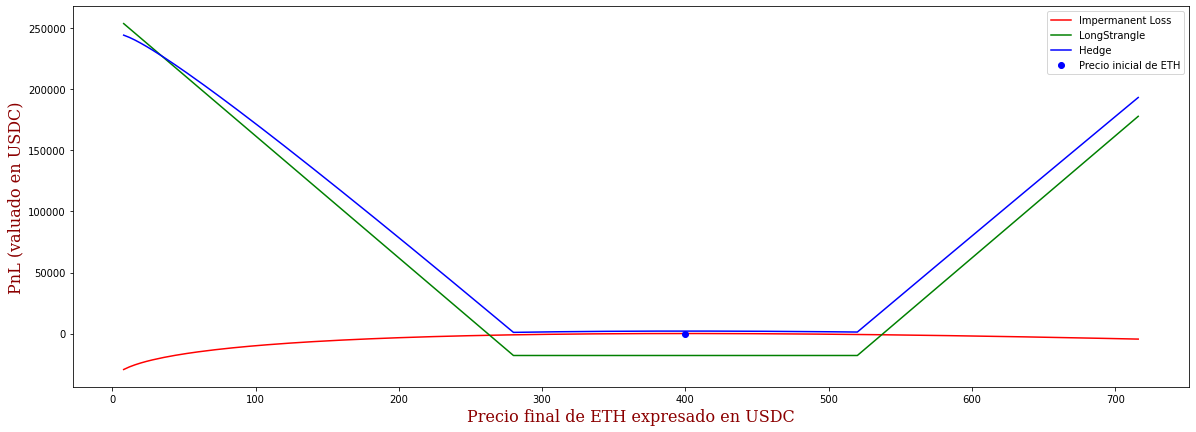

<class 'list'>
<class 'numpy.ndarray'>


In [87]:
# Generación de gráfico
grid = np.arange(leftmost,rightmost,step)

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1)

r_pool = 0.25 # 0.002
P_entry = get_pool_initial_price(pool_balances)
V_hold_0 = get_pool_value(pool_balances, get_prices_vector(P_entry))
retornos_usd_pool = r_pool * V_hold_0
costos = (cant_call*precio_call)+(cant_put*precio_put)
if costos > retornos_usd_pool:
    print(f'WARNING: Fees del pool: {retornos_usd_pool} < costo opciones {costos}')
axs.plot(grid*P_entry, IL_Y_P(grid*P_entry, pool_balances), c='red', label='Impermanent Loss')
axs.plot(grid*P_entry, payoff_CP_combination(grid*P_entry, strike_call, strike_put, precio_call, precio_put, cant_call, cant_put), c='green', label='LongStrangle')
axs.plot(grid*P_entry, payoff_IL_hedgeada_con_LS(grid*P_entry, pool_balances, precio_inicial, strike_call, strike_put, precio_call, precio_put, cant_call, cant_put, r_pool), c='blue', label='Hedge')

#axs.set_title('Profit and Loss', fontdict=font)
#plt.text(0,0, f'Fee = 0', fontdict=font)

axs.set_xlabel(f'Precio final de {pool_symbols[0]} expresado en {pool_symbols[1]}', fontdict=font)
axs.set_ylabel(f'PnL (valuado en {pool_symbols[1]})', fontdict=font)
axs.plot(P_entry, 0, 'bo', label=f'Precio inicial de {pool_symbols[0]}')
#axs.set_ylim(-1000,1000)
axs.legend()
plt.show()

#grid2 = np.arange(-1, 2, 0.2)
#pd.DataFrame([[str(round(i*100,3))+'%',
#               str(round((i+1)*100,3))+'%',
#               str(round(abs(IL_Y_P(i+1, pool_balances)),1)*100)+'%'] for i in grid2],
#             columns = ['Price change', 'R', 'IL ratio']).T

#v1 = payoff_IL_hedgeada_con_LS_parcial(pool_balances, get_pool_initial_price(pool_balances), retorno_del_pool_a_tiempo_final) * np.ones(len(grid))
#print(type(v1))
v2bis = [payoff_CP_combination(g*P_entry, strike_call, strike_put, precio_call, precio_put,cant_call,cant_put) for g in grid]
print(type(v2bis))
v3 = IL_Y_P(grid*P_entry, pool_balances)
print(type(v3))
v4 = v2bis+v3




#axs.plot(grid*P_entry, IL_Y_P(grid*P_entry, pool_balances), c='red', label='Impermanent Loss')
#axs.plot(grid*P_entry, payoff_CP_combination(grid*P_entry, strike_call, strike_put, precio_call, precio_put, cant_call, cant_put), c='green', label='LongStrangle')
#axs.plot(grid*P_entry, v1, c='red', label='Hedge1 - pool')
axs.plot(grid*P_entry, v2bis, c='green', label='Hedge2 - strangle')
axs.plot(grid*P_entry, v3, c='blue', label='Hedge3 - IL')
axs.plot(grid*P_entry, v4, c='orange', label='Hedge4 - Total')


## Ejemplo práctico

### Obtención de datos de mercado

#### Obtener cotizaciones (Binance)

En esta sección armamos código para traer datos históricos de Binance.

##### Parámetros

In [88]:
## Parámetros para obtener datos desde Binance

# initial_date = '1 Jan 2022' # respetar este formato de fecha
initial_date = '1 Jan 2022'

# pools = ["ETHUSDC", "ETHUSDT", "BTCUSDT"]

# monedas y tokens: BTC ETH MATIC UNI COMP AAVE YFI CRV MKR LINK KP3R SFI SUSHI 1INCH CAKE 

symbol = "ETHUSDC"

# Frecuencia: 1m, 5m, 10m, 15m, 1h, 1d, 1w, 1M
freq = "1d"

# Máxima cantidad de registros a guardar
# maxnum=2000


##### Código

In [11]:
!pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.0 MB/s 
     |████████████████████████████████| 288 kB 8.4 MB/s 
     |████████████████████████████████| 112 kB 43.2 MB/s 
     |████████████████████████████████| 749 kB 40.8 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [89]:
import pandas as pd
import math
import os.path
import time
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
binance_api_key = '9zFIgetckRO80d4RciWs8jc4XSwAMEnFIuwVhAoaYIstQ9RWlfqiV6zcAGu0Ta8R'    #Enter your own API-key here
binance_api_secret = 'Uu8vtNEmH1PPDPDchX51jivxBENEbNwDmDcQrnhPJBJwFcbqjnvxL2MeQJuTc4Kg' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "6h": 360, "12h": 720, "1d": 1440}

batch_size = 750
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime(initial_date, '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime(initial_date, '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [90]:

# Descarga de datos
ETH_historico = get_all_binance(symbol, freq, save = True)

len(ETH_historico)

## Debugging:
#ETH_historico

# Me quedo con los últimos maxnum registros
P_ETH = ETH_historico['close']
for i in range(len(P_ETH)):
  P_ETH[i] = float(P_ETH[i])

print(len(P_ETH))


All caught up..!
318


<ipython-input-90-8d4ddc75c7f5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_ETH[i] = float(P_ETH[i])


##### Gráfico

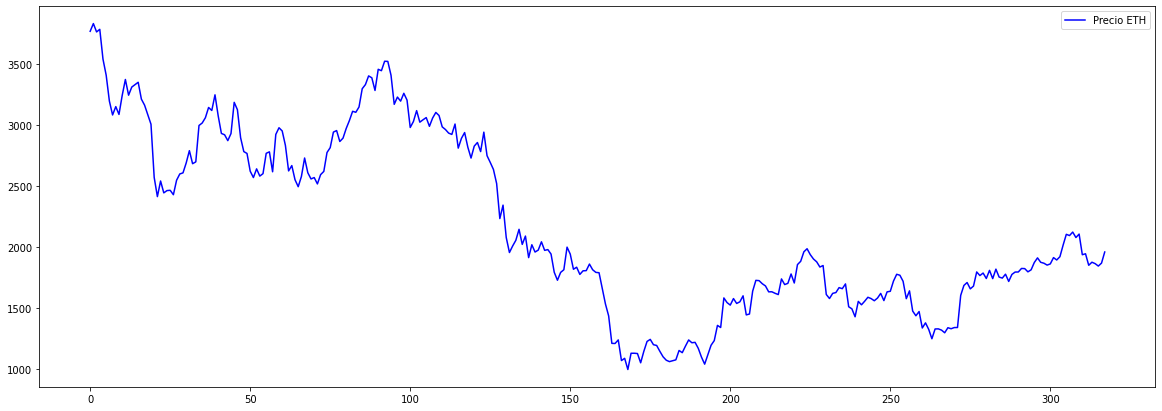

In [91]:
import matplotlib.pyplot as plt
# plt.plot(list(P_ETH))
# plt.figsize(20,7)
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(list(P_ETH), c='blue', label = 'Precio ETH')
axs.legend()

#### Obtener cotizaciones (Deribit)

En esta sección tenemos código para traer datos y cotizaciones de opciones desde Deribit.

##### Parámetros

In [92]:
## Parámetros para obtener datos de opciones desde Deribit

instrument_name = "ETH" # BTC, ETH or SOL

# cada contrato de opciones sobre ETH y BTC en Deribit corresponde a 1 única
# unidad subyacente.

multiplier = 1 


##### Código

In [93]:

import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [94]:

def get_all_instruments():
  import urllib.request, json
  url = f"https://test.deribit.com/api/v2/public/get_instruments"
  with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
  return data

# Get a list of all active BTC options from the Deribit API.
def get_all_active_options(instrument_name="BTC"):
    import urllib.request, json
    url =  f"https://test.deribit.com/api/v2/public/get_instruments?currency={instrument_name}&kind=option&expired=false"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data['result']).set_index('instrument_name')
    data['creation_date'] = pd.to_datetime(data['creation_timestamp'], unit='ms')
    data['expiration_date'] = pd.to_datetime(data['expiration_timestamp'], unit='ms')
    print(f'{data.shape[0]} active options.')
    return data

# Filter options based on data available from 'get_instruments'
def filter_options(price, active_options):
    # price is the current price of BTC
    
    #Get Put/Call information
    pc = active_options.index.str.strip().str[-1]
    
    # Set "moneyness"
    active_options['m'] = np.log(active_options['strike']/price)
    active_options.loc[pc=='P','m'] = -active_options['m']
    # Set days until expiration
    active_options['t'] = (active_options['expiration_date']-pd.Timestamp.today()).dt.days
    
    # Only include options that are less than 30% from the current price and have less than 91 days until expiration
    active_options = active_options.query('m>0 & m<.3 & t<91')
    
    print(f'{active_options.shape[0]} active options after filter.')
    return active_options

# Get Tick data for a given instrument from the Deribit API
def get_tick_data(instrument_name="BTC"):
    import urllib.request, json
    url =  f"https://test.deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.json_normalize(data['result'])
    data.index = [instrument_name]
    return data

# Loop through all filtered options to get the current 'ticker' datas
def get_all_option_data(instrument_name="BTC"):
    option_data = get_tick_data(f'{instrument_name}-PERPETUAL')
    options = filter_options(option_data['last_price'][0], get_all_active_options(instrument_name))
    for o in options.index:
        option_data = option_data.append(get_tick_data(o))
    return option_data



In [95]:
option_data = get_all_option_data(instrument_name)

358 active options.
68 active options after filter.


<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed fro

<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  option_data = option_data.append(get_tick_data(o))
<ipython-input-94-1e4c8e35271a>:54: FutureWarning: The frame.append method is deprecated and will be removed fro

In [96]:
### Add additional metrics to data
option_data['daystoexpiration'] = np.nan; option_data['t'] = np.nan; option_data['strike'] = np.nan; option_data['callput'] = np.nan
# Calculated days until expiration
#option_data.loc[1:,'t'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
option_data.loc[1:,'daystoexpiration'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
option_data.loc[1:,'t'] = option_data[1:].index.map(lambda x: x.split('-')[1]).astype(str)
# Pull strike from instrument name
option_data.loc[1:,'strike'] = option_data[1:].index.map(lambda x: x.split('-')[2]).astype(int)
# pull callput
option_data.loc[1:, 'callput'] = option_data[1:].index.map(lambda x: x.split('-')[3]).astype(str)
# Calculate "moneyness"
option_data['m'] = np.log(option_data['last_price'][0]/option_data['strike'])

<ipython-input-96-a83a62fe20fb>:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  option_data.loc[1:,'daystoexpiration'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
<ipython-input-96-a83a62fe20fb>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  option_data.loc[1:,'t'] = option_data[1:].index.map(lambda x: x.split('-')[1]).astype(str)
<ipython-input-96-a83a62fe20fb>:8: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  option_data.loc[1:,'strike'] = option_data[1:].index.map(lambda x: x.split('-')[2]).astype(int)
<ipython-input-96-a83a62fe20fb>:10: FutureWarning: 

In [21]:
## Debugging:
#print(option_data)
#print(option_data.columns)
#print(option_data['daystoexpiration'])

##### Datos obtenidos

In [97]:
print(option_data[(option_data.callput == 'C')]['last_price'])
print(option_data[(option_data.callput == 'P')]['last_price'])

ETH-27APR23-1975-C       NaN
ETH-27APR23-2000-C       NaN
ETH-27APR23-2050-C       NaN
ETH-27APR23-2100-C       NaN
ETH-27APR23-2150-C       NaN
ETH-27APR23-2200-C       NaN
ETH-28APR23-2000-C    0.0005
ETH-28APR23-2100-C    0.0115
ETH-28APR23-2200-C    0.0065
ETH-28APR23-2400-C    0.0005
ETH-28APR23-2500-C    0.0005
ETH-28APR23-2600-C    0.0005
ETH-5MAY23-2000-C     0.0270
ETH-5MAY23-2100-C     0.0515
ETH-5MAY23-2200-C     0.0005
ETH-5MAY23-2300-C        NaN
ETH-5MAY23-2400-C        NaN
ETH-5MAY23-2500-C        NaN
ETH-5MAY23-2600-C        NaN
ETH-26MAY23-2000-C    0.0555
ETH-26MAY23-2100-C    0.0785
ETH-26MAY23-2200-C    0.0350
ETH-26MAY23-2300-C       NaN
ETH-26MAY23-2400-C    0.0325
ETH-26MAY23-2500-C    0.0220
ETH-26MAY23-2600-C    0.0160
ETH-30JUN23-2000-C    0.1260
ETH-30JUN23-2100-C    0.0855
ETH-30JUN23-2200-C    0.0840
ETH-30JUN23-2300-C    0.0445
ETH-30JUN23-2400-C    0.3000
ETH-30JUN23-2600-C    0.0095
Name: last_price, dtype: float64
ETH-27APR23-1500-P       NaN
ETH-27APR2

## Elección de strikes para hedging

### Cómputo de volatilidad histórica

Calculamos la volatilidad histórica del subyacente en base a los datos obtenidos de Binance, a fin de estimar el valor de la volatilidad, la cual usaremos para ver en qué rango hedgear. También puede ser útil para utilizarla en Black-Scholes, usando BSM para elegir los mejores precios de opciones disponibles. En el Anexo IV se encuentra bocetado el código correspondiente.

#### Código

In [98]:
def get_ema_std_vol_of_returns(hist_data, alpha, min_periods):
  # Rolling Volatility (annualized assuming 365 trading days)
  # 2 week
  # historical_data = hist_data[-2*30*24:].copy()
  historical_data = hist_data.copy()
  historical_data_return = np.around(historical_data.pct_change().dropna(), 3)
  ema_of_com_in_periods = historical_data_return.ewm(alpha=alpha, min_periods=min_periods)
  vol = ema_of_com_in_periods.std()
  historical_data_vol = vol
  vol_annualized = vol * np.sqrt(365)
  historical_data_vol_ann = vol_annualized
  return {'vol_ema_of_returns_respect_to_periods': vol,
          'vol_ema_of_returns_annualized': vol_annualized}

def get_ema_std_vol_of_prices(historical_data, alpha, min_periods):
  # Rolling Volatility (annualized assuming 365 trading days)
  # 2 week
  # historical_data['returns'] = np.around(historical_data['close'].pct_change().dropna(), 3)
  ema_of_com_in_periods = historical_data.ewm(alpha=alpha, min_periods=min_periods)
  vol = ema_of_com_in_periods.std()
  historical_data_vol = vol
  vol_annualized = vol * np.sqrt(365)
  historical_data_vol_ann = vol_annualized
  return {'vol_ema_of_prices_respect_to_periods': vol,
          'vol_ema_of_prices_annualized': vol_annualized}

#### Resultado

Usando los datos recibidos de Binance para calcular la volatilidad histórica, elegimos $P_i$ y $P_s$ como cotas para la región [P_i,P_0]del PnL, la cual pretendemos hedgear.

In [99]:
sigma = np.mean(get_ema_std_vol_of_returns(P_ETH, 0.95, 15)['vol_ema_of_returns_respect_to_periods'])
#sigma = 5
factor_de_seguridad = 5

print(f'sigma = {sigma}')
margen_a_hedgear = sigma * factor_de_seguridad
print(f'Margen para hedgear: {margen_a_hedgear}')

precio_activo = option_data["underlying_price"][1] # último precio registrado = precio Spot (S)
P_s = precio_activo*(1+margen_a_hedgear)
P_i = precio_activo*(1-margen_a_hedgear)
print(f'P_s = {precio_activo*(1+margen_a_hedgear)}')
print(f'P_0 = {precio_activo}')
print(f'P_i = {precio_activo*(1-margen_a_hedgear)}')


sigma = 0.037017699885714066
Margen para hedgear: 0.18508849942857034
P_s = 2264.7826937755103
P_0 = 1911.0663
P_i = 1557.34990622449


#### Seleccionamos las opciones

En el informe mostramos un resultado que nos asegura cobertura en el intervalo $[P_i,P_s]$ siempre que 
\begin{align*}
    \frac{c}{2}(\frac{1}{\sqrt{K_pP_0}} - \frac{1}{P_0})&\leq q_p\\
     D-\min\{IL(K_c),IL(K_P)\}&\leq r_p c\\
    -\frac{c}{2}(\frac{1}{\sqrt{K_c P_0}}-\frac{1}{P_0})&\leq q_c
\end{align*}
con $c$ el capital inicial; $q_p,q_c$ la cantidad de puts y calls a comprar respectivamente; $D$ el costo de las opciones.

Filtremos entonces las opciones disponibles para un cierto rango de dias y con strikes tales que  $K_p\in [P_i,P_0]$ y $K_c\in [P_0,P_s]$.

In [100]:

call_min_days_to_expiration = 20
call_max_days_to_expiration = 60
put_min_days_to_expiration = 20
put_max_days_to_expiration = 60

print(f'Option name\tDays to expiration')
print(option_data[(option_data.callput == 'C')&\
                  (option_data.daystoexpiration >= put_min_days_to_expiration)&
                  (option_data.daystoexpiration <= put_max_days_to_expiration)&\
                  (precio_activo <= option_data.strike)&(option_data.strike <= P_s)])#['daystoexpiration'])

print(option_data[(option_data.callput == 'P')&\
                  (option_data.daystoexpiration >= put_min_days_to_expiration)&
                  (option_data.daystoexpiration <= put_max_days_to_expiration)&\
                  (precio_activo >= option_data.strike)&(option_data.strike >= P_i)]['daystoexpiration'])
   
#option_data [option_data.strike == K_put]["instrument_name"]
#option_data [option_data.strike == K_call]["instrument_name"]

Option name	Days to expiration
                        timestamp state  settlement_price  open_interest  \
ETH-26MAY23-2000-C  1682512714709  open          0.028906         6213.0   
ETH-26MAY23-2100-C  1682512714705  open          0.018880          401.0   
ETH-26MAY23-2200-C  1682512715712  open          0.010813         1962.0   

                    min_price  max_price  mark_price  last_price  \
ETH-26MAY23-2000-C     0.0001     0.5495      0.0495      0.0555   
ETH-26MAY23-2100-C     0.0001     0.5335      0.0337      0.0785   
ETH-26MAY23-2200-C     0.0001     0.5460      0.0463      0.0350   

                    interest_value     instrument_name  ...  greeks.vega  \
ETH-26MAY23-2000-C             NaN  ETH-26MAY23-2000-C  ...      2.24056   
ETH-26MAY23-2100-C             NaN  ETH-26MAY23-2100-C  ...      2.10081   
ETH-26MAY23-2200-C             NaN  ETH-26MAY23-2200-C  ...      2.07823   

                    greeks.theta  greeks.rho  greeks.gamma  greeks.delta  \
ETH-26MAY2

Filtramos las opciones calls y puts con 
- expiracion entre los dias min y max que definimos antes
- strike < P_s para el call
- strike > P_i para el put

In [104]:
call_options_available = option_data[(option_data.callput == 'C')&\
                  (option_data.daystoexpiration >= put_min_days_to_expiration)&
                  (option_data.daystoexpiration <= put_max_days_to_expiration)&\
                  (precio_activo <= option_data.strike)&(option_data.strike <= P_s)]
put_options_available = option_data[(option_data.callput == 'P')&\
                  (option_data.daystoexpiration >= put_min_days_to_expiration)&
                  (option_data.daystoexpiration <= put_max_days_to_expiration)&\
                  (precio_activo >= option_data.strike)&(option_data.strike >= P_i)]

In [109]:
call_options_available[['daystoexpiration', 'strike', 'mark_price']], P_s

(                    daystoexpiration  strike  mark_price
 ETH-26MAY23-2000-C              29.0  2000.0      0.0495
 ETH-26MAY23-2100-C              29.0  2100.0      0.0337
 ETH-26MAY23-2200-C              29.0  2200.0      0.0463,
 2264.7826937755103)

In [110]:
put_options_available[['daystoexpiration', 'strike', 'mark_price']], P_i

(                    daystoexpiration  strike  mark_price
 ETH-26MAY23-1600-P              29.0  1600.0      0.0042
 ETH-26MAY23-1700-P              29.0  1700.0      0.0106
 ETH-26MAY23-1800-P              29.0  1800.0      0.0350
 ETH-26MAY23-1900-P              29.0  1900.0      0.0574,
 1557.34990622449)

In [111]:
call = call_options_available[(call_options_available.daystoexpiration == 29.0)&
                  (call_options_available.strike == 2000)]
put = put_options_available[(put_options_available.daystoexpiration == 29.0)&
                  (put_options_available.strike == 1600)]

In [112]:
print(call["strike"])
print(put["strike"])

ETH-26MAY23-2000-C    2000.0
Name: strike, dtype: float64
ETH-26MAY23-1600-P    1600.0
Name: strike, dtype: float64


In [113]:
Kcall = float(call['strike'])
Kput = float(put['strike'])
dcall = float(call['mark_price']*precio_activo)
dput = float(put['mark_price']*precio_activo)
qcall = 100
qput = 100

In [115]:
Kcall, Kput, dcall, dput, qcall, qput, dcall* qcall+ dput* qput

(2000.0, 1600.0, 94.59778185, 8.02647846, 100, 100, 10262.426031)

Luego de ver esa lista elegimos la fecha de ejercicio que aparezca tanto en las calls como en las puts (designándola mediante la cantidad de días restantes para la expiración).

### Gráfico

In [117]:
# Grilla a graficar
leftmost = 1-2*margen_a_hedgear
rightmost = 1+2*margen_a_hedgear
step = 0.01

In [43]:
# Librerías a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

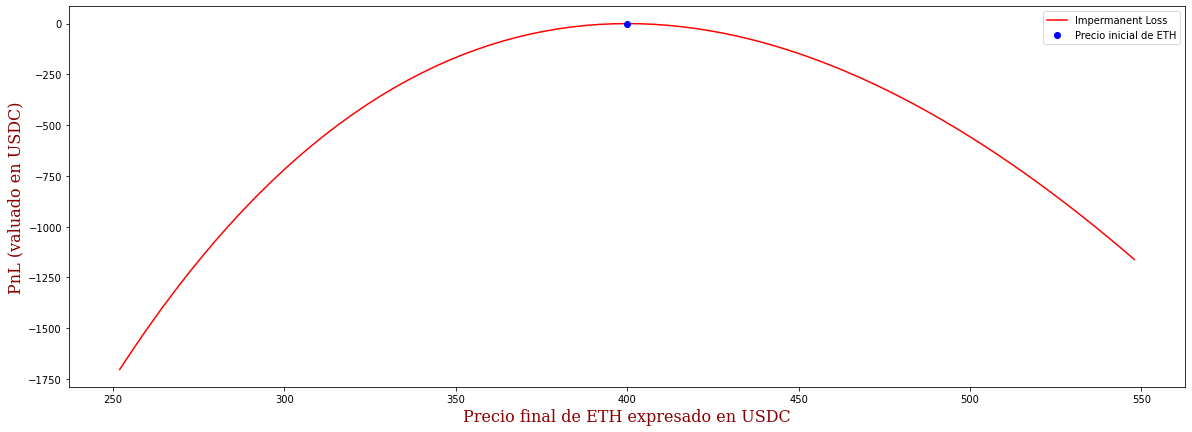

In [118]:
# Generación de gráfico
grid = np.arange(leftmost,rightmost,step)

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1)

P_entry = get_pool_initial_price(pool_balances)
axs.plot(grid*P_entry, IL_Y_P(grid*P_entry, pool_balances), c='red', label='Impermanent Loss')

#axs.set_title('Profit and Loss', fontdict=font)
#plt.text(0,0, f'Fee = 0', fontdict=font)

axs.set_xlabel(f'Precio final de {pool_symbols[0]} expresado en {pool_symbols[1]}', fontdict=font)
axs.set_ylabel(f'PnL (valuado en {pool_symbols[1]})', fontdict=font)
axs.plot(P_entry, 0, 'bo', label=f'Precio inicial de {pool_symbols[0]}')
axs.legend()
plt.show()

#grid2 = np.arange(-1, 2, 0.2)
#pd.DataFrame([[str(round(i*100,3))+'%',
#               str(round((i+1)*100,3))+'%',
#               str(round(abs(IL_Y_P(i+1, pool_balances)),1)*100)+'%'] for i in grid2],
#             columns = ['Price change', 'R', 'IL ratio']).T


Veamos cómo queda el PnL final.

In [119]:
def IL(p,bal_usdc, bal_eth, precio_activo):
    v_0 = bal_usdc + bal_eth*precio_activo
    return v_0/2 *((p/precio_activo)**(1/2) - 1/2 - p/(2*precio_activo))

In [120]:
price_change= np.arange(-1,3,0.01)

pool_balances = (100, precio_activo*100)
balance_usdc = pool_balances[1]
balance_eth = pool_balances[0]
precio_activo = balance_usdc/balance_eth
r_p = 0.15/12  # radio mensual por proveer liquidez
P = precio_activo*(1+ price_change)
V_h_0 = balance_usdc + balance_eth*precio_activo

In [121]:
V_h_0=balance_usdc + balance_eth*precio_activo
cte_call=V_h_0/2*(1/np.sqrt(P_i*precio_activo)-1/precio_activo)
cte_put=-V_h_0/2*(1/np.sqrt(P_s*precio_activo)-1/precio_activo)

In [122]:
cte_call, cte_put

(10.775769761444414, 8.140387679598271)

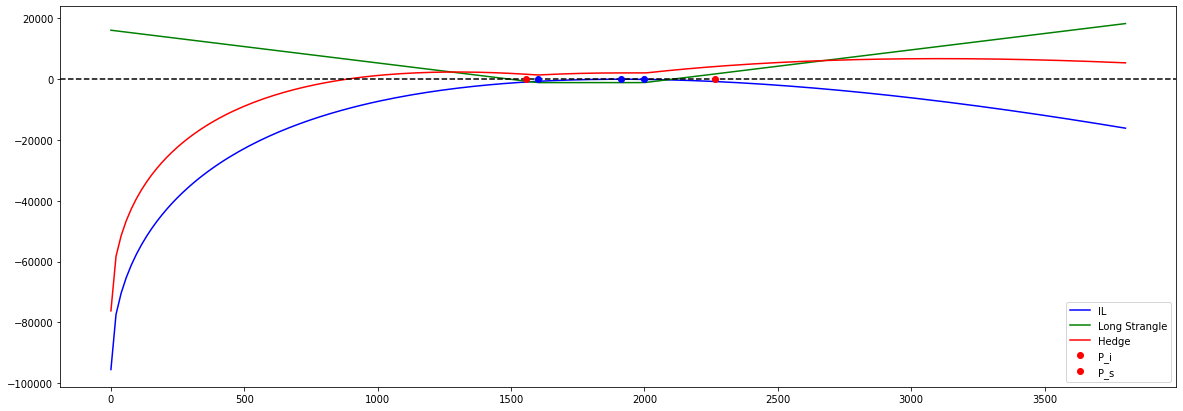

In [140]:
# Parameters
price_change= np.arange(-2*margen_a_hedgear,2*margen_a_hedgear,0.01)
price_change= np.arange(-1,1,0.01)

pool_balances = (100, precio_activo*100)
balance_usdc = pool_balances[1]
balance_eth = pool_balances[0]
precio_activo = balance_usdc/balance_eth

r_p = 0.1 / 12 # retorno mensual por proveer liquidez
P = precio_activo*(1+ price_change)
V_h_0 = balance_usdc + balance_eth*precio_activo

retorno_del_pool_a_tiempo_final=r_p* V_h_0 # ¿sobre las tenencias inicial?

# Opt Parameters
K_put =  Kput
K_call =  Kcall
d_call = dcall
d_put = dput
q_call =  np.max([cte_put,cte_call])#qcall*np.ones(100)[0]
q_put = q_call  #qput*np.ones(100)[0]

# Stgy calcs
opt_stg = [payoff_CP_combination(p,K_call,K_put,d_call,d_put,q_call,q_put) for p in P] 
IL_sin_hedg_usd = [IL(p, balance_usdc, balance_eth, precio_activo) for p in P]
IL_con_hedg_usd = retorno_del_pool_a_tiempo_final*np.ones(len(P)) + IL_sin_hedg_usd + opt_stg

# WARNING
costos = (q_call*dcall)+(q_put*dput)
if costos > retorno_del_pool_a_tiempo_final:
    print(f'WARNING: Fees del pool: {retorno_del_pool_a_tiempo_final} < costo opciones {costos}')

    
# Plot
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(P, IL_sin_hedg_usd, c = 'blue', label = 'IL')
axs.plot(P, opt_stg, c = 'green', label = 'Long Strangle' )
axs.plot(P, IL_con_hedg_usd, c = 'red', label = 'Hedge')

axs.axhline(y = 0, color = 'black', linestyle = '--')
axs.plot(precio_activo, 0, 'bo')
axs.plot(P_i, 0, 'ro', label='P_i')
axs.plot(P_s, 0, 'ro', label='P_s')
axs.plot(Kcall, 0, 'bo')
axs.plot(Kput, 0, 'bo')
# axs.set_xlim([1000,2000])
axs.legend()
plt.show()

A continuacion printeamos si hay hedge o no, comparando si retornos + IL < costos 

(False = Hedge es rentable; True = Hedge no es rentable)

In [141]:
print( q_call*dcall + q_put*dput- np.min([IL(K_call, balance_usdc, balance_eth, precio_activo), IL(K_put, balance_usdc, balance_eth, precio_activo)])-retorno_del_pool_a_tiempo_final>= 0)

False


In [142]:
D = q_call*dcall + q_put*dput
V_h_0
print("Capital inicial: ", V_h_0)
print("Costo total: ", D)
print("pcg: ", D/V_h_0)

Capital inicial:  382213.26
Costo total:  1105.855401039098
pcg:  0.0028932941809478247


## Bibliografía

<a name="referencia1">[1]</a> Angeris, Guillermo & Kao, Hsien-Tang & Chiang, Rei & Noyes, Charlie & Chitra, Tarun. (2020). An Analysis of Uniswap markets. Cryptoeconomic Systems. 10.21428/58320208.c9738e64.
 

## Apéndice I: Notación

La notación utilizada en la bibliografía de referencia \[[1](#referencia1)\] se vincula del siguiente modo con la que empleamos aquí:

$$ coins:\ (\alpha,\beta) \rightarrow (X, Y)$$
$$ time: t_1 , t_2,...,T \rightarrow 0, T \ ^{(*)}$$
$$ reserves\ for\ coin\ \alpha\ at\ time\ t_1: R_\alpha^{t_1} \rightarrow x_0 \ ^{(*)}$$
$$ reserves\ for\ coin\ \beta\ at\ time\ t_1\ ^{(**)}: R_\beta^{t_1} = \sqrt{k\ m_P^{t_1}}\rightarrow y_0 = \sqrt{k\ P_0}\ ^{(*)}$$
$$ reserves\ for\ coin\ \alpha\ at\ time\ T: R_\alpha^T \rightarrow x \ ^{(*)}$$
$$ reserves\ for\ coin\ \beta\ at\ time\ T\ ^{(**)}: R_\beta^T = \sqrt{k\ m_P^T} \rightarrow y = \sqrt{k\ P} \ ^{(*)}$$
$$ market\ price\ of\ coin\ \alpha\ at\ time\ t_1\ ^{(**)}: m_p^1 = R_\beta^{t_1} / R_\alpha^{t_1} \rightarrow P_0 = y_0 / x_0$$
$$ market\ price\ of\ coin\ \alpha\ at\ time\ T\ ^{(**)}: m_p^T = R_\beta^T / R_\alpha^T \rightarrow P = y / x $$
$$ constant\ product\ for\ all\ times\ t : k = R_\alpha^t \ R_\beta^t \rightarrow k = x\ y = x_0\ y_0$$
$$ liquidity\ provider's\ relative\ return\ between\ time\ t_1\ and\ T\ ^{(**)}: \delta = \sqrt{\frac{m_p^t}{m_p^1}} \rightarrow \sqrt{\frac{P}{P_0}}= \sqrt{R}$$
$$ total\ portfolio\ value\ ^{(**)}: P_V = 2 \sqrt{k m_P^T} \rightarrow V_{Pool_t} = 2 \sqrt{k P}$$


$^{(*)}$ Ver [nota](#alcances) sobre alcances del presente trabajo.

$^{(**)}$ Ecuaciones válidas solo para el caso sin fees.


## Apéndice II: Fórmulas para la Impermanent Loss con fees

Presentamos aquí fórmulas y funciones incorporando fees para el cálculo de la Impermanent Loss.

Sean $fee=\tau$, $\phi = 1-\tau$, $P:=p^{bid^1}$ y $P_0:=p^{bid^0}$. Sabiendo que $p^b = \phi P_{Y|X} = \phi \frac{y}{x}$, $R=\frac{P_{Y|X}}{P^0_{Y|X}}=\frac{p^b}{p^b_0}$ y que $V_{Hold} = a+b*p^b$, tenemos

\begin{align*}
  IL^{fee}_{\%}(R) &= \sqrt{R}\frac{1+\phi}{\phi R+1} -1 \Rightarrow \frac{\partial}{\partial R}IL^{fee}_{\%}(R) = \frac{1+\phi}{(1+\phi R)^2}\frac{1-\phi R}{2\sqrt{R}}\\
  IL^{fee}_{\%}(P) &= \sqrt{PP_0}\frac{1+\phi}{P_0+\phi P}-1 \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{\%}(P) = \frac{1+\phi}{2}\sqrt{\frac{P_0}{P}}\frac{P_0-\phi P}{(P_0+\phi P)^2}\\ 
  IL^{fee}_{USD}(P) &= IL^{fee}_{\%}(P)*V_{Hold} \text{ una forma} \\
  &= \frac{V_H^0}{2}\left(\sqrt{\frac{P}{P_0}}\frac{1+\phi}{\phi}-\frac{P_0+\phi P}{P_0\sqrt{\phi}}\right) \text{ otra forma} \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{USD}(P) = \frac{V_H^0}{2P_0}\left(\frac{1}{2}\sqrt{\frac{P_0}{P}}\frac{1+\phi}{\phi}-\sqrt{\phi}\right)
\end{align*}

In [ ]:
# Impermanent Loss porcentual en función de R con fees
def IL_R_fee(R,fee):
  phi = 1-fee
  return R**(1/2)*(1+phi)/(1+R*phi)-1
# Impermanent Loss porcentual en función de P con fees
def IL_P_fee(P,fee):
  phi = 1-fee
  return IL_R_fee(P/P_entry,fee)
  # return (P*P_entry)**(1/2)*(1+phi)/(P_entry+phi*P)-1
# Impermanent Loss en USD en función de P con fees
def IL_P_in_usd_fee(P,fee):
  phi = 1-fee
  # P = R * P_entry
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  # p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return V_hold_0/2 * ( (p_bid/p_bid_entry)**(1/2) * (1+phi)/phi - (p_bid_entry + phi*p_bid) / (p_bid_entry*phi**(1/2)) )
  # return IL_R_in_usd_fee(P/P_entry,fee)
# Derivada de IL porcentual en función de R con fees
def IL_derivada_R_fee(R, fee):
  phi = 1-fee
  return (1+phi)/(1+phi*R)**2 * (1-phi*R)/(2*R**(1/2))
# Derivada de IL porcentual en función de P con fees
def IL_derivada_P_fee(P,fee):
  phi = 1-fee
  p_bid_entry = P_entry * phi
  p_bid = P *  phi
  return IL_derivada_R_fee(P/P_entry, fee) / p_bid_entry
  # return (1+phi)/2 * (p_bid_entry/p_bid)**(1/2) * (p_bid_entry-phi*p_bid)/(p_bid_entry+phi*p_bid)**2
# Derivada de IL en USD en función de P con fees
def IL_derivada_P_in_usd_fee(P,fee):
  phi = 1-fee
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return IL_derivada_P_fee(P,fee) * V_hold + IL_P_fee(P, fee) * tenencias_inicial[1] 
  # return V_hold_0/(2*p_bid_entry) * ( 1/2*(p_bid_entry/p_bid)**(1/2) * (1+phi)/phi - phi**(1/2) )

## Apéndice III: Replicador estático para mercados de producto constante (CPM)

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm 

In [ ]:
"""
opcion_europea_bs
Def
    Calculador del precio de una opcion Europea con el modelo de Black Scholes
Inputs
    - tipo : string - Tipo de contrato entre ["CALL","PUT"]
    - S : float - Spot price del activo
    - K : float - Strike price del contrato
    - T : float - Tiempo hasta la expiracion (en años)
    - r : float - Tasa 'libre de riesgo' (anualizada)
    - sigma : float - Volatilidad implicita (anualizada)
    - div : float - Tasa de dividendos continuos (anualizada)
Outputs
    - precio_BS: float - Precio del contrato
"""

def opcion_europea_bs(tipo, S, K, T, r, sigma, div):
    #Defino los ds
    d1 = (np.log(S / K) + (r - div + 0.5 * sigma * sigma) * T) / sigma / np.sqrt(T)
    d2 = (np.log(S / K) + (r - div - 0.5 * sigma * sigma) * T) / sigma / np.sqrt(T)

    if (tipo == "C"):
        precio_BS = np.exp(-div*T) *S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif (tipo == "P"):
        precio_BS = K * np.exp(-r * T) * norm.cdf(-d2) - np.exp(-div*T) * S * norm.cdf(-d1)
    return precio_BS

### Ejemplo: Replicando un CPM con bonos, futuros y opciones

Consideremos un mercado de producto constante con estado 
    $$ (t,R_a,R_b) = (1,10,200) $$

El precio de $\beta$ es unidades de $\alpha$ es $m_p ^1 = \frac{R_\beta}{R_{\alpha}}$.
El valor inicial del pool (en unidades de $\beta$) es 
$$P_V ^1 = (m_p ^1 R_{\alpha}^{1}+R_{\beta}^{1})=0.005*200 + 10 = 20 $$  

El portfolio replicador es:


Valor nominal del bono: $f(m^{0})= 2\sqrt{km^{0}}= 2\sqrt{2000*0.05}=20$

Valor nocional de futuros $m^0$: $f'(m^0)=\sqrt{\frac{k}{m^{0}}}= \sqrt{\frac{2000}{0.05}}=200$

Valor nocional de las opciones con strike $K$:  $f''(K)=-\frac{1}{2}\sqrt{\frac{k}{K^3}} dK = -\frac{0.0125}{2}\sqrt{\frac{2000}{K^3}} dK$


Si por ejemplo tenemos un numero discreto de strikes $K=(0.125, 0.025, . . . , 0.1)$ el payoff al vencimiento nos queda 

$$
    P_V^{T}=f(m^0)+f'(m^0)(m^T-m^0)+
     \sum_{K\leq m_p ^{0}}f''(K)P(K)\Delta K +\sum_{K>m_p ^0} f''(K)C(K)\Delta K.
$$


In [ ]:
def face_value_bond (x, k):
    return 2*np.sqrt(k*x)
def notional_future (x, k): 
    return np.sqrt(k/x)  
def notional_option (x, delta_x, k):
    return -(1/2)*np.sqrt(k/(x**3))*(delta_x)


def replicator_with_option_discr_bs(m_T, m_0, K, k):
    # Parámetros para las opciones
    T = 1
    r = 0.1
    div = 0
    sigma = 0.2
    bond = face_value_bond(m_0, k)
    futures = notional_future(m_0,k)*(m_T-m_0)
    sum_calls = 0
    sum_puts = 0
    for i in range(1, len(K)):
        if K[i] > m_0: 
            sum_calls = sum_calls + notional_option(K[i],K[i]-K[i-1],k)*opcion_europea_bs("C", m_T, K[i], T, r , sigma, div)
        else:
            sum_puts = sum_puts + notional_option(K[i],K[i]-K[i-1],k)*opcion_europea_bs("P", m_T, K[i], T, r , sigma, div)
    return bond + futures + sum_calls + sum_puts           

In [ ]:
S = np.linspace(0, 0.1, 6) # rango a graficar 
m_0 = 0.05
k= 2000
# strikes
K = np.linspace(0.0125,0.1,8)

replicator_discr_bs = replicator_with_option_discr_bs(S,m_0,K,k)
#Grafico el Strangle

fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(S, replicator_discr_bs, c = 'blue', label = 'replicated payoff')
axs.plot(S, 2*np.sqrt(k*S), c = 'red', label = 'P_V ^T')
axs.axhline(y = 0, color = 'black', linestyle = '--')
axs.legend()
plt.plot()

## Apéndice IV: Valuación de opciones europeas mediante BSM

Si bien teníamos la idea de utilizar el modelo de Black-Scholes-Merton junto con la volatilidad histórica para saber si los precios de opciones que obtuvimos tienen un precio razonable o no, finalmente optamos por no hacerlo para acotar la longitud del trabajo. También puede utilizarse para calcular la volatilidad teórica que correspondería a los precios observados.

### Código

In [ ]:
!pip install QuantLib

In [ ]:
### Modelado de opciones europeas con BSM (QuantLib)

import numpy as np
import QuantLib as ql 
from QuantLib.QuantLib import nullInt
from pandas.core.base import DataError
from datetime import timedelta, datetime

def payoff(tipo, precio, strike):
  if tipo == 'CALL':
    tipo_opcion = ql.Option.Call
  elif tipo == 'PUT':
    tipo_opcion = ql.Option.Put
  return ql.PlainVanillaPayoff(tipo_opcion, strike)

def tasa_constante(fecha_valuacion, tasa_interes):
  return ql.YieldTermStructureHandle(ql.FlatForward(fecha_valuacion, 
                                                    tasa_interes, 
                                                    ql.Actual365Fixed()))

def get_valor_tasa(objeto_tasa, fecha_expiracion):
  return objeto_tasa.forwardRate(objeto_tasa.fecha_valuacion, 
                                 fecha_expiracion, 
                                 ql.Actual365Fixed(), 
                                 ql.Continuous).rate()

def volatilidad(fecha_valuacion, calendario, valor_volatilidad):
  return ql.BlackVolTermStructureHandle(
                          ql.BlackConstantVol(fecha_valuacion, 
                                              calendario, 
                                              valor_volatilidad, 
                                              ql.Actual365Fixed()
                                              )
                          )

def get_valor_volatilidad(objeto_volatilidad, fecha_expiracion, base):
  return objeto_volatilidad.blackVol(fecha_expiracion, base)

def proceso_BSM(precio_activo, fecha_valuacion, val_volatilidad, tasa_interes, 
                tasa_dividendos, calendario):
  ql.Settings.instance().evaluationDate = fecha_valuacion
  objeto_spot = ql.QuoteHandle(ql.SimpleQuote(precio_activo))
  objeto_tasa_interes = tasa_constante(fecha_valuacion, tasa_interes)
  objeto_tasa_dividendos = tasa_constante(fecha_valuacion, tasa_dividendos)
  objeto_volatilidad = volatilidad(fecha_valuacion, calendario, val_volatilidad)
  return ql.BlackScholesMertonProcess(objeto_spot, 
                                      objeto_tasa_dividendos, 
                                      objeto_tasa_interes, 
                                      objeto_volatilidad)

def precio_opcion_europea_BSM(tipo, precio, base, vencimiento, proceso_BSM):
  ejercicio_europeo = ql.EuropeanExercise(vencimiento)
  opcion_europea = ql.VanillaOption(payoff(tipo, precio, base), 
                                    ejercicio_europeo)
  opcion_europea.setPricingEngine(ql.AnalyticEuropeanEngine(proceso_BSM))
  return max(opcion_europea.NPV(),0)


### Parámetros

In [ ]:

valor_volatilidad = 0.3394  #Volatilidad Implicita anualizada (sigma)
tasa_interes = 0.0325 #tasa libre de riesgo anualizada (r) - tomo US02Y
tasa_dividendos =  0.0 #tasa de dividendos anualizada (q)

##Valuacion el 18 de julio de 2022
#fecha_valuacion = ql.Date(18, 7, 2022)
##Valuacion con fecha de hoy
fecha_valuacion = datetime.now()
fecha_valuacion = ql.Date(int(fecha_valuacion.strftime('%d')),
                            int(fecha_valuacion.strftime('%m')),
                            int(fecha_valuacion.strftime('%Y')))
#fecha_valuacion = ql.Date(28,7,2022)
##Expiracion el 16 de agosto de 2022
fecha_expiracion = ql.Date(28, 8, 2022)
# Mercado de USA
calendario = ql.UnitedStates()



### Resultados

In [ ]:
precio_activo = option_data["underlying_price"][1]
print("Precios de opciones europeas de ETH evaluadas con fecha " +
      str(fecha_valuacion) +
      " sabiendo que: \n" +
      "\tprecio actual " + str(precio_activo) + "\n" +
      "\tvolatilidad " + str(valor_volatilidad) + "\n" +
      "\ttasa libre de riesgo "+ str(tasa_interes) + "\n" +
      "\ttasa dividendos "+ str(tasa_dividendos))

for (base, tipo) in (K_put, 'PUT'), (K_call, 'CALL'):
    print("Precio de opción europea " + str(tipo) + " strike " + 
            str(base) +" vencimiento "+ str(fecha_expiracion) +" según BSM: "+ 
            str(precio_opcion_europea_BSM(tipo, 
                                      precio_activo, 
                                      base, 
                                      fecha_expiracion,  
                                      proceso_BSM(precio_activo, 
                                                   fecha_valuacion, 
                                                   valor_volatilidad, 
                                                   tasa_interes, 
                                                   tasa_dividendos, 
                                                   calendario)
                                      )
               )
            )


